#### Hotel Booking Demand dataset from the Kaggle.
You can download it from here:
https://www.kaggle.com/jessemostipak/hotel-booking-demand

#### We will try to answer the following questions
How Many Booking Were Cancelled?

What is the booking ratio between Resort Hotel and City Hotel?

What is the percentage of booking for each year?

Which is the busiest month for hotels?

From which country most guests come?

How Long People Stay in the hotel?

Which was the most booked accommodation type (Single, Couple, Family)?

#### We will build a predictive model to predict whether the booking will be canceled or not by:
Performing Feature Engineering to make new features

Performing Feature Selection to select only relevant features

Transforming the Data (Categorial to Numerical)

Splitting the data (Train Test Split)

Modeling the data (Fit the Data)

And finally, Evaluating our model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from pandas.core.common import SettingWithCopyWarning
from warnings import simplefilter
simplefilter(action="ignore", category=SettingWithCopyWarning)

pd.options.display.max_columns = None

In [2]:
data = pd.read_csv('hotel_bookings.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
## Copy the dataset
df = data.copy()

### Dealing with Missing Values

In [5]:
## Find the missing value, show the total null values for each column and sort it in descending order
df.isnull().sum().sort_values(ascending=False)[:10]

company                   112593
agent                      16340
country                      488
children                       4
reserved_room_type             0
assigned_room_type             0
booking_changes                0
deposit_type                   0
hotel                          0
previous_cancellations         0
dtype: int64

In the agent and the company column, we have id_number for each agent or company, so for all the missing values, we will just replace it with 0.

Children column contains the count of children, so we will replace all the missing values with the rounded mean value.

Country column contains country codes representing different countries. It is a categorical feature so we will also replace it with the mode value.

In [6]:
## If no id of agent or company is null, just replace it with 0
df[['agent','company']] = df[['agent','company']].fillna(0.0)
df[['agent','company']].isnull().value_counts()

agent  company
False  False      119390
dtype: int64

In [7]:
## for missing children value, replace it with rounded mean value
df.children = df.children.fillna(round(df.children.mean()))
df.children.describe()

count    119390.000000
mean          0.103886
std           0.398555
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: children, dtype: float64

In [8]:
## For the missing values in the country column, replace it with mode (value that appears most often)
df.country = df.country.fillna(df.country.mode().to_string())
df.country.isnull().value_counts()

False    119390
Name: country, dtype: int64

#### Many rows that have zero guests including adults, children and babies

In [9]:
df[(df.adults+df.children+df.babies)==0].shape

(180, 32)

We have 180 rows with 0 values. We will just remove these rows.

In [10]:
## Drop Rows where adult, baby and child have 0 values
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)
df[(df.adults+df.children+df.babies)==0].shape

(0, 32)

### Converting Datatype

In [11]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

#### Converting float values in children, company, and agent to integer

In [12]:
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

### 1. How Many Booking Were Cancelled?

In [13]:
percent_canx=df['is_canceled'].value_counts()/len(df['is_canceled'])
percent_canx

0    0.629234
1    0.370766
Name: is_canceled, dtype: float64

is_canceled have two unique values: 1 if booking got canceled, else 0; cancellation percentage is 37.07%

<AxesSubplot:>

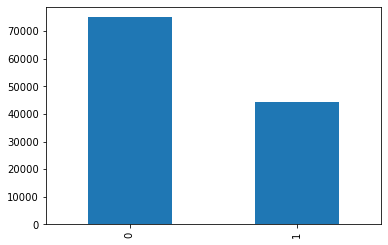

In [14]:
df.is_canceled.value_counts().plot.bar()

For further analysis, We will select only those bookings which did not get canceled

In [15]:
df_not_canceled = df[df['is_canceled'] == 0]

### 2. What is the booking ratio between Resort Hotel and City Hotel?

In [16]:
df_not_canceled['hotel'].value_counts()

City Hotel      46084
Resort Hotel    28927
Name: hotel, dtype: int64

<AxesSubplot:>

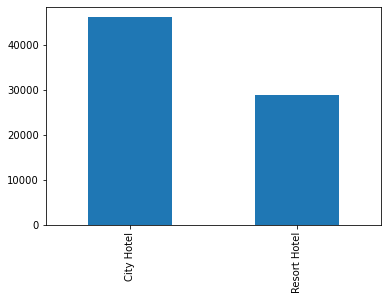

In [17]:
df_not_canceled['hotel'].value_counts().plot.bar()

In [18]:
percent_bookings=df_not_canceled['hotel'].value_counts()/len(df_not_canceled['hotel'])
percent_bookings

City Hotel      0.614363
Resort Hotel    0.385637
Name: hotel, dtype: float64

More than 60% of the population booked the City hotel

### 3. What is the percentage of booking for each year?

In [19]:
df_not_canceled['arrival_date_year'].value_counts()

2016    36299
2017    24886
2015    13826
Name: arrival_date_year, dtype: int64

<AxesSubplot:>

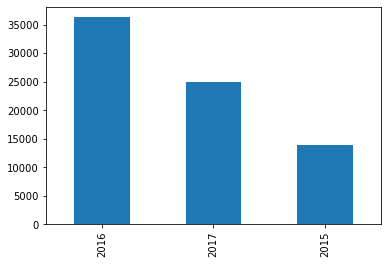

In [20]:
df_not_canceled['arrival_date_year'].value_counts().plot.bar()

In [21]:
df_not_canceled_2015=df_not_canceled[(df_not_canceled.arrival_date_year==2015)]

In [22]:
percent_bookings_2015=df_not_canceled_2015['hotel'].count()/len(df_not_canceled['arrival_date_year'])
percent_bookings_2015

0.18431963312047567

In [23]:
df_not_canceled_2016=df_not_canceled[(df_not_canceled.arrival_date_year==2016)]

In [24]:
percent_bookings_2016=df_not_canceled_2016['hotel'].count()/len(df_not_canceled['arrival_date_year'])
percent_bookings_2016

0.4839156923651198

In [25]:
df_not_canceled_2017=df_not_canceled[(df_not_canceled.arrival_date_year==2017)]

In [26]:
percent_bookings_2017=df_not_canceled_2017['hotel'].count()/len(df_not_canceled['arrival_date_year'])
percent_bookings_2017

0.33176467451440456

#### More than double bookings were made in 2016, compared to the previous year. But the bookings decreased by almost 15% the next year.

<AxesSubplot:xlabel='arrival_date_year', ylabel='count'>

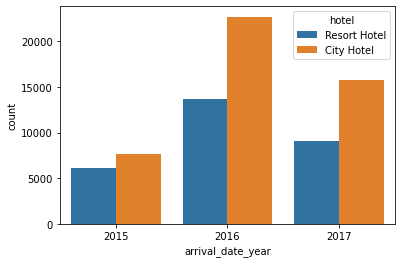

In [27]:
sns.countplot(x='arrival_date_year', hue='hotel',  data=df_not_canceled)

### 4. Which is the busiest month for hotels?

To answer this question, we will select the arrival_date_month feature and get its value count. Now the resulting data will not be sorted according to month order so we have to sort it. We will make the new list with the names of months in order to sort our data according to this list.

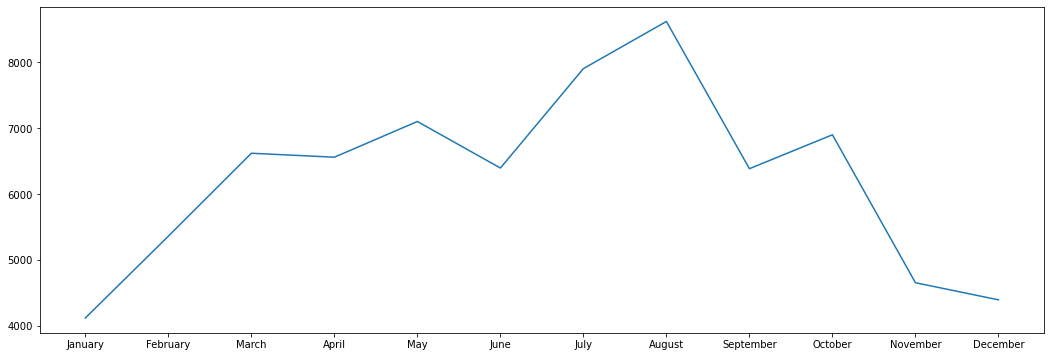

In [28]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
             'October', 'November', 'December']

sorted_months = df_not_canceled['arrival_date_month'].value_counts().reindex(new_order)
plt.rcParams['figure.figsize']=(18,6)
plt.plot(sorted_months)

#### As we can see most bookings were made from July to August. And the least bookings were made at the start and end of the year.

Let’s separate the data for each hotel type and then see the trend.

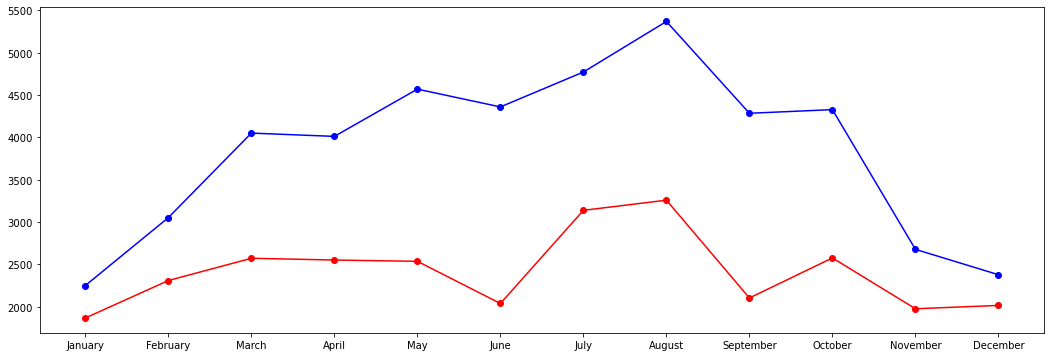

In [29]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
             'November', 'December']
## Select only City Hotel
sorted_months_city = df_not_canceled.loc[df.hotel=='City Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)

## Select only Resort Hotel
sorted_months_resort = df_not_canceled.loc[df.hotel=='Resort Hotel' ,'arrival_date_month'].value_counts().reindex(new_order)
plt.rcParams['figure.figsize']=(18,6)
plt.plot(sorted_months_city,'b-o')
plt.plot(sorted_months_resort,'r-o')

#### We can see the trend is kind of similar with a small difference. Resort has more bookings at the start and end of the year, and lower booking in June and September.

### 5. From which country most guests come?

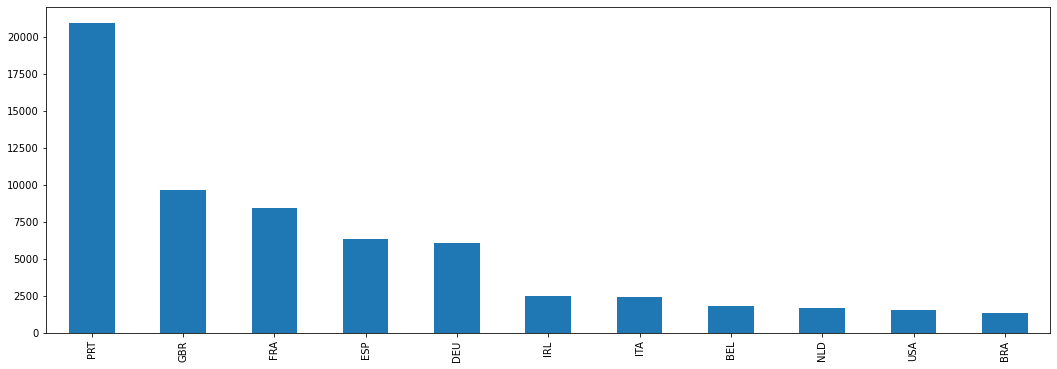

In [30]:
df_not_canceled['country'].value_counts()[:11].plot.bar()
plt.rcParams['figure.figsize']=(18,6)

#### Portugal, UK and France, Spain and Germany are the top countries from most guests come, more than 80% come from these 5 countries.

### 6. How Long People Stay in the hotel?

<AxesSubplot:>

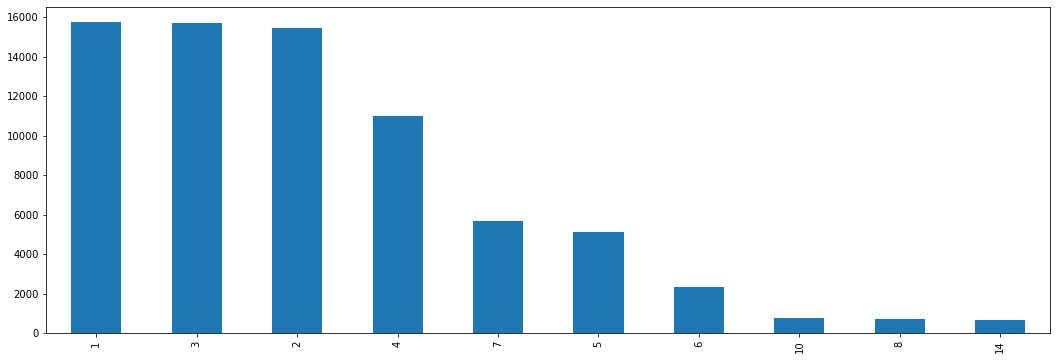

In [31]:
total_nights = df_not_canceled['stays_in_weekend_nights']+ df_not_canceled['stays_in_week_nights']
total_nights.value_counts()[:10].plot.bar()

#### Most people stay for one, two, or three.

Let’s see the stay duration trend for each hotel type.

In [32]:
df_not_canceled['total_nights']= df_not_canceled['stays_in_weekend_nights']+ df_not_canceled['stays_in_week_nights']

<AxesSubplot:xlabel='total_nights', ylabel='count'>

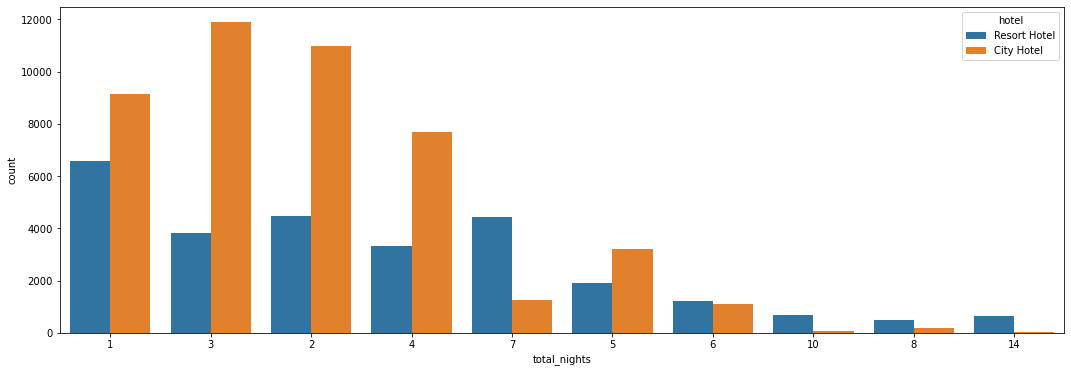

In [33]:
sns.countplot(x='total_nights', hue='hotel', data=df_not_canceled,
              order = df_not_canceled.total_nights.value_counts().iloc[:10].index)

For City hotel, the most popular stay duration is three, two, one, and four days respectively.
For Resort hotel, most popular stay duration is one, two, seven(week), and three respectively

### 7. Which was the most booked accommodation type (Single, Couple, Family)?

We will divide people staying in the hotel into 3 categories.

Single: 1 Adult only

Couple: 2 Adults

Family or Friends: More than 2 people including adults, children, and babies.

In [34]:
## Select single, couple, multiple adults and family
single   = df_not_canceled[(df_not_canceled.adults==1) & (df_not_canceled.children==0) & (df_not_canceled.babies==0)]
couple   = df_not_canceled[(df_not_canceled.adults==2) & (df_not_canceled.children==0) & (df_not_canceled.babies==0)]
family   = df_not_canceled[(df_not_canceled.adults + df_not_canceled.children + df_not_canceled.babies > 2)]

Number of bookings for single, couple, family

In [35]:
single.shape[0],couple.shape[0], family.shape[0]

(16022, 49136, 9506)

<AxesSubplot:>

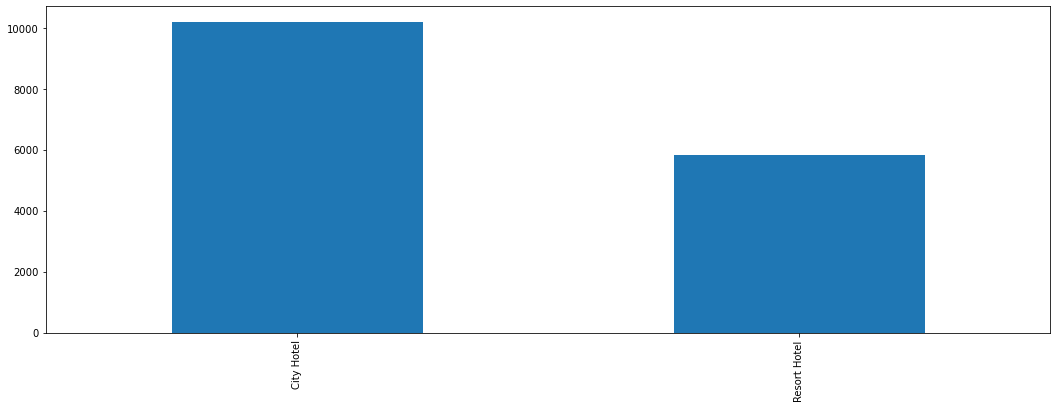

In [36]:
single['hotel'].value_counts().plot.bar()

<AxesSubplot:>

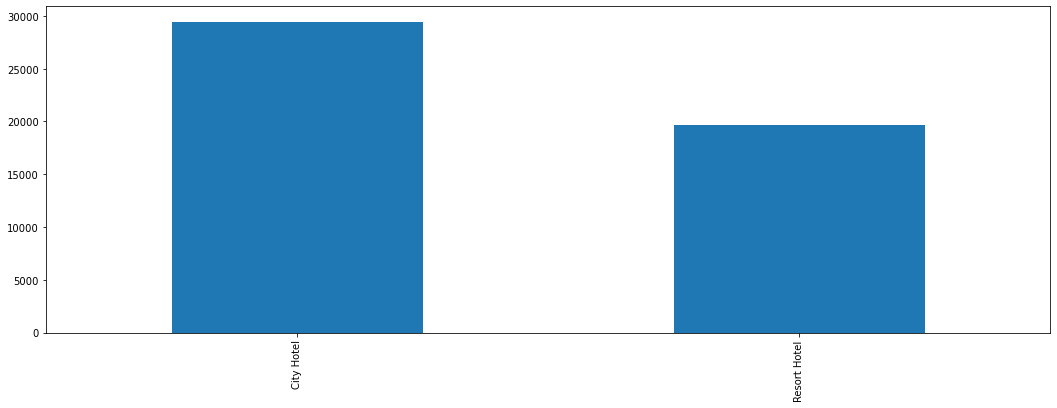

In [37]:
couple['hotel'].value_counts().plot.bar()

<AxesSubplot:>

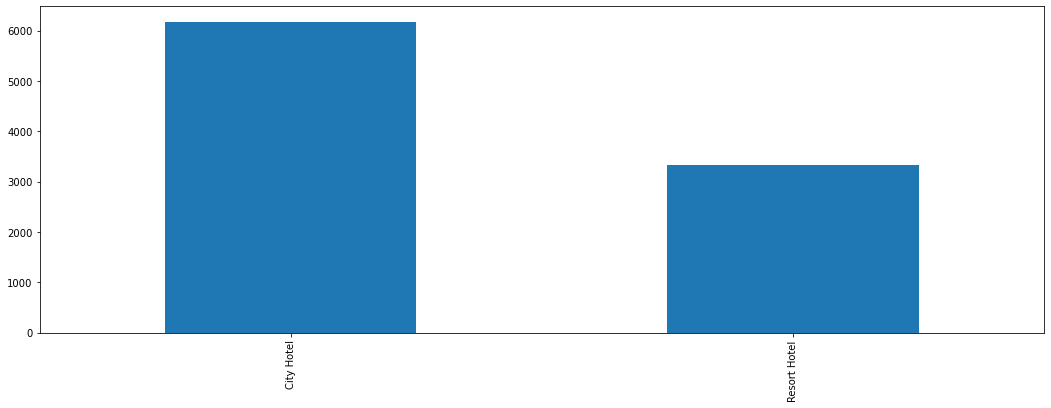

In [38]:
family['hotel'].value_counts().plot.bar()

Couple (or 2 adults) is the most popular accommodation type. So hotels can make plans accordingly

### Feature Selection and Feature Engineering

making a copy of dataframe.

In [39]:
df_subset = df.copy()

#### Creating some new features.

We have two features in our dataset reserved_room_type and another is assigned_room_type. We will make the new feature let’s call it Room which will contain 1 if the guest was assigned the same room that was reserved else 0. Guest can cancel the booking if he did not get the same room.

Another feature will be net_cancelled. It will contain 1 If the current customer has canceled more bookings in the past than the number of bookings he did not cancel, else 0.

In [40]:
df_subset['Room'] = 0
df_subset.loc[ df_subset['reserved_room_type'] == df_subset['assigned_room_type'] , 'Room'] = 1
df_subset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,98.0,0,1,Check-Out,2015-07-03,1


In [41]:
df_subset['net_cancelled'] = 0
df_subset.loc[ df_subset['previous_cancellations'] > df_subset['previous_bookings_not_canceled'] , 'net_cancelled'] = 1
df_subset.loc[df_subset.net_cancelled==1]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Room,net_cancelled
13988,Resort Hotel,1,11,2016,July,28,4,1,3,1,0,0,BB,0 PRT,Corporate,Direct,0,1,0,A,A,0,No Deposit,0,39,0,Transient,65.00,0,0,Canceled,2016-06-23,1,1
13989,Resort Hotel,0,11,2016,October,44,24,1,3,1,0,0,BB,0 PRT,Corporate,Direct,0,1,0,A,A,0,No Deposit,0,39,0,Transient,52.00,0,0,Check-Out,2016-10-28,1,1
14125,Resort Hotel,1,249,2016,December,52,20,2,5,2,0,0,BB,0 PRT,Direct,Direct,0,1,0,E,E,1,No Deposit,0,0,0,Transient,42.00,0,2,Canceled,2016-12-19,1,1
14181,Resort Hotel,1,21,2016,December,53,30,1,2,2,0,0,BB,0 PRT,Direct,Direct,0,1,0,A,A,0,No Deposit,0,0,0,Transient,150.00,0,0,Canceled,2016-12-16,1,1
14182,Resort Hotel,0,80,2017,June,23,9,2,2,2,0,0,FB,PRT,Direct,Direct,0,1,0,F,F,1,No Deposit,250,0,0,Transient,195.00,0,0,Check-Out,2017-06-13,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87648,City Hotel,1,5,2016,September,38,12,1,1,1,0,0,BB,ESP,Aviation,Corporate,1,2,1,D,D,0,No Deposit,0,153,0,Transient,110.00,0,0,Canceled,2016-09-08,1,1
87649,City Hotel,0,10,2016,September,40,30,2,2,1,0,0,BB,ESP,Aviation,Corporate,1,2,1,D,D,0,No Deposit,0,153,0,Transient,110.00,0,0,Check-Out,2016-10-04,1,1
89166,City Hotel,1,4,2017,June,24,11,2,2,1,0,0,BB,PRT,Aviation,Corporate,1,2,1,D,D,0,No Deposit,0,153,0,Transient,110.00,0,0,Canceled,2017-06-08,1,1
89167,City Hotel,1,8,2017,June,24,17,2,2,1,0,0,BB,PRT,Aviation,Corporate,1,2,1,D,D,0,No Deposit,0,153,0,Transient,110.00,0,0,Canceled,2017-06-17,1,1


#### removing unnecessary features

In [42]:
df_subset = df_subset.drop(['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month',
                            'arrival_date_month','assigned_room_type','reserved_room_type','reservation_status_date',
                            'previous_cancellations','previous_bookings_not_canceled','reservation_status'],axis=1)

#### plotting the heatmap to see the correlation

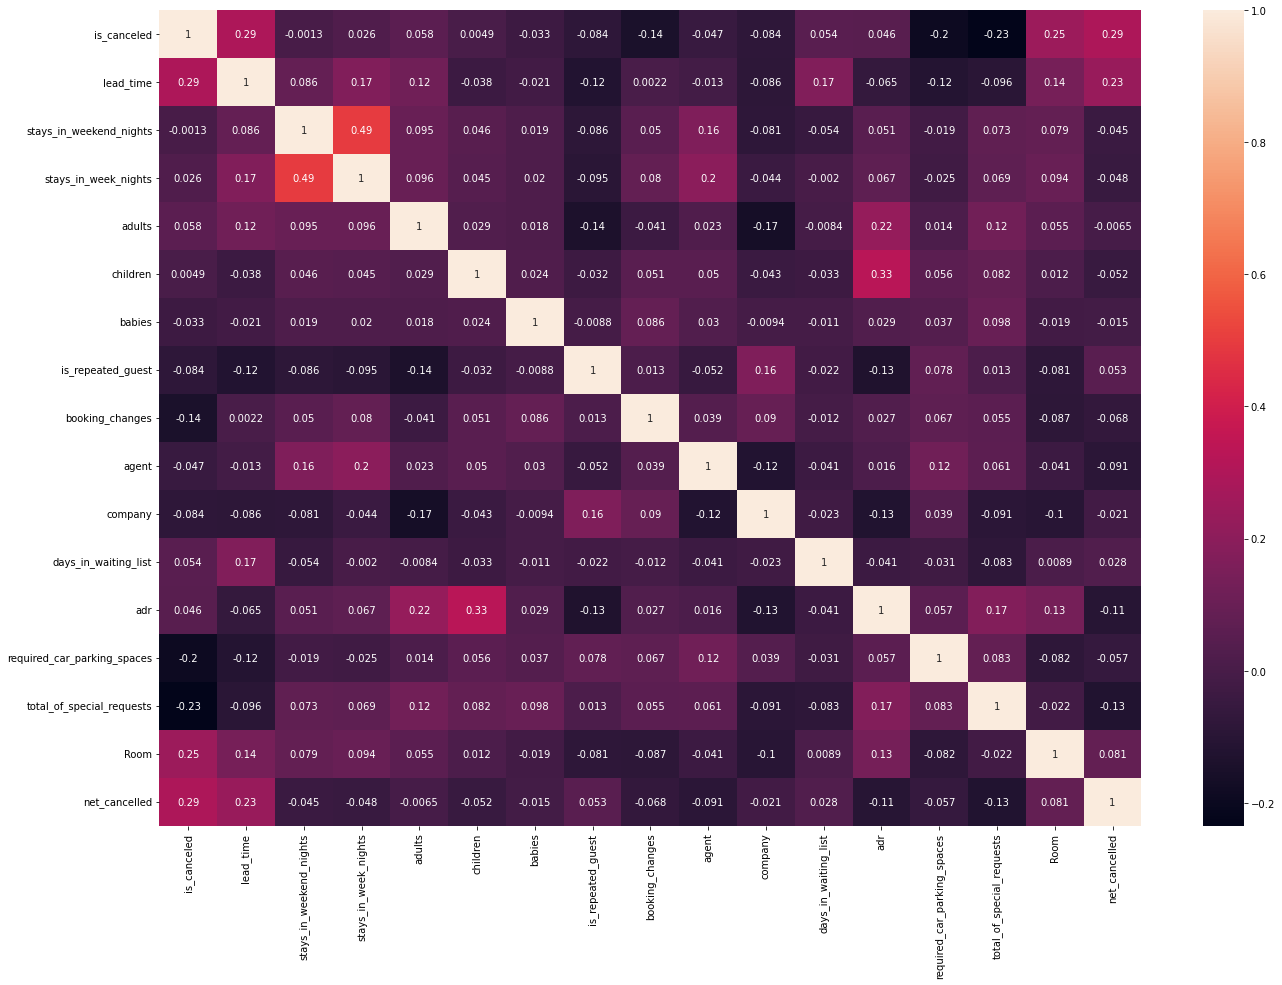

In [43]:
fig, ax = plt.subplots(figsize=(22,15))
sns.heatmap(df_subset.corr(), annot=True, ax=ax);

#### We can see our new features, Room and net_cancelled have a higher correlation with is_cancelled than most of the other columns.

### Modeling

#### 1. Converting Categorical variables to Numerical

In [44]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [45]:
dff=df_subset.drop('is_canceled', axis=1)

In [46]:
numerical_features=dff.select_dtypes(include=np.number).columns.tolist()

In [47]:
categorical_features = list(dff.columns[dff.dtypes == object])
dff[categorical_features]=dff[categorical_features].apply(lambda x: encoder.fit_transform(x))

#### 2. Train Test Split

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X = dff[numerical_features+categorical_features]
Y = df_subset['is_canceled']

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=42)

#### 3. Machine Learning Model (Decision Tree)

In [51]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train,y_train)

DecisionTreeClassifier(random_state=42)

#### 4. Evaluation of the Model

In [52]:
train_score = clf.score(x_train,y_train)
test_score = clf.score(x_test,y_test)
train_score, test_score

(0.9954925229568155, 0.8542764151259941)

#### Let’s pick any random sample and try to make the prediction and compare it with the actual values

In [53]:
## Getting Prediciton of 10th record of x_train
prediction = clf.predict(x_train.iloc[10].values.reshape(1,-1))
prediction

array([1], dtype=int64)

In [54]:
## Actual Value of 10th record of x_train from y_train
actual_value = y_train.iloc[10]
actual_value

1